In [1]:
%load_ext autoreload
%autoreload 2

# Dataset Creation

In [2]:
from preprocess import make_dataset
import pandas as pd
import numpy as np
import os

# Extract all the midi files 

midi_files = []

for path, subdirs, files in os.walk(r'./data/'):
    for name in files:
        if (name.endswith('.mid')):
            midi_files.append(os.path.join(path, name))

In [33]:
TEST_FILE = r'./data/Rick Astley/Never Gonna Give You Up.mid'
df = make_dataset(midi_files, file_name="datasets/midi-dataset-flat.csv")


Processing Files...: 100%|██████████| 17256/17256 [1:44:10<00:00,  2.76files/s, ./data/_Weird Al_ Yankovic\Headline News.mid]                                                                                                                                                                                                                                                                


In [9]:
import pretty_midi
from models.data_split import NUM_MIDI_NOTES, VOCABULARY
import matplotlib.pyplot as plt
import librosa

In [26]:
toks = df.iloc[0]['notes']
durations = df.iloc[0]['durations']
times = df.iloc[0]["times"]
velocities = df.iloc[0]['velocities']

In [27]:
midi_file = pretty_midi.PrettyMIDI(resolution=384)

piano = pretty_midi.Instrument(0)

time = 0
tpq = midi_file.resolution

v_itr = 0
d_itr = 0
t_itr = 0

for i, tok in enumerate(toks):
    duration = durations[d_itr]

    if tok < NUM_MIDI_NOTES:
        note = pretty_midi.Note(velocity=velocities[v_itr], pitch=tok, start=time / tpq, end=(time + duration) / tpq)
        v_itr += 1
        piano.notes.append(note)
    elif tok == VOCABULARY['EOS']:
        break # Stop Generating for EOS
    elif tok == VOCABULARY['SEP']:
        d_itr += 1
    elif tok == VOCABULARY['BEAT']:
        time += times[t_itr]
        t_itr += 1


midi_file.instruments.append(piano)

midi_file.write("test.mid")

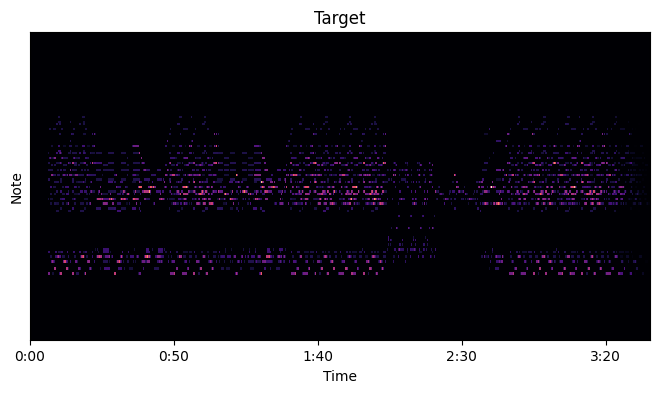

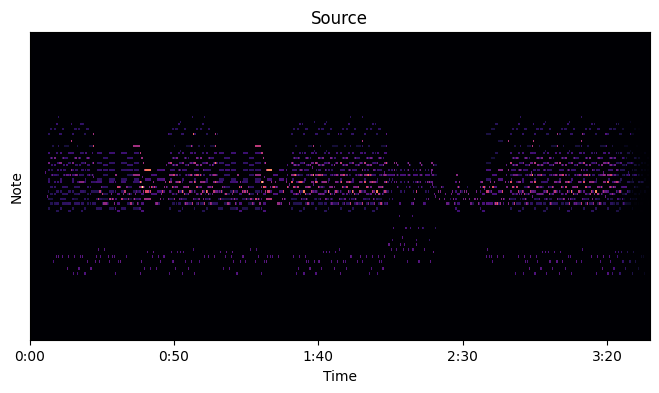

384


In [28]:
fs = 100

plt.figure(figsize=(8, 4))
plt.title("Target")
librosa.display.specshow(midi_file.get_piano_roll(fs),
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note')
plt.show()

fs = 100

target = pretty_midi.PrettyMIDI(TEST_FILE)
plt.figure(figsize=(8, 4))
plt.title("Source")
librosa.display.specshow(target.get_piano_roll(fs),
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note')
plt.show()

print(target.resolution)

# Dataset Analysis

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv("datasets/midi-dataset-flat.csv")

In [5]:
lengths = df.notes.apply(lambda x: len(x))

(array([1.233e+03, 4.445e+03, 4.728e+03, 3.186e+03, 1.818e+03, 7.890e+02,
        3.740e+02, 1.930e+02, 8.400e+01, 4.400e+01, 2.500e+01, 1.700e+01,
        5.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00]),
 array([   766.   ,   9881.125,  18996.25 ,  28111.375,  37226.5  ,
         46341.625,  55456.75 ,  64571.875,  73687.   ,  82802.125,
         91917.25 , 101032.375, 110147.5  , 119262.625, 128377.75 ,
        137492.875, 146608.   , 155723.125, 164838.25 , 173953.375,
        183068.5  , 192183.625, 201298.75 , 210413.875, 219529.   ,
        228644.125, 237759.25 , 246874.375, 255989.5  , 265104.625,
        274219.75 , 283334.875, 292450.   ]),
 <BarContainer object of 32 artists>)

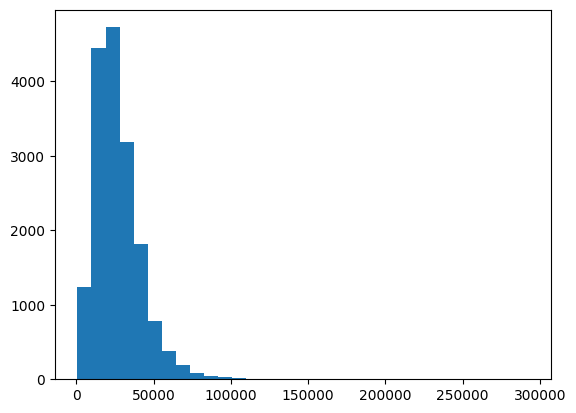

In [7]:
plt.hist(lengths, bins=128)

In [49]:
df['notes'] = df.notes.apply(lambda x: [int(y) for y in str(x).removeprefix('[').removesuffix(']').split(' ') if y.isnumeric()])
df['velocities'] = df.velocities.apply(lambda x: [int(y) for y in str(x).removeprefix('[').removesuffix(']').split(' ') if y.isnumeric()])
df['times'] = df.times.apply(lambda x: [float(y) for y in str(x).removeprefix('[').removesuffix(']').split(' ') if y.replace('.', '').replace('e+', '').replace('e-','').isnumeric()])
df['durations'] = df.durations.apply(lambda x: [float(y) for y in str(x).removeprefix('[').removesuffix(']').split(' ') if y.replace('.', '').replace('e+', '').replace('e-','').isnumeric()])

In [50]:
print(df.iloc[11088])

plt.plot(df['times'][11088])

IndexError: single positional indexer is out-of-bounds

In [ ]:
note_bins = [0 for i in range(0, 200)]
velocity_bins = [0 for i in range(0, 128)]
duration_means = []
duration_std = []

time_means = []
time_std = []

for i in range(0, len(df['notes'])):
    for x in df['notes'][i]:
        note_bins[x] += 1

    for x in df['velocities'][i]:
        velocity_bins[x] += 1
    
    duration_means.append(np.mean(df['durations'][i]))
    duration_std.append(np.std(df['durations'][i]))

    time_means.append(np.mean(df['times'][i]))
    time_std.append(np.std(df['times'][i]))


In [ ]:
plt.plot(note_bins)
plt.xlim((0, 127))
plt.ylim(0, max(note_bins[0:128]))
plt.show()

In [ ]:
p = duration_means
q = duration_std
p[np.argmax(duration_means)] = 0
q[np.argmax(duration_std)] = 0

plt.scatter(p, q)

In [ ]:
p = time_means
q = time_std
p[np.argmax(time_means)] = 0
p[np.argmax(time_means)] = 0

q[np.argmax(time_std)] = 0
q[np.argmax(time_std)] = 0

plt.scatter(p,q)

In [ ]:
plt.plot(velocity_bins)
plt.xlim((0, 127))
plt.ylim(0, max(velocity_bins[0:128]))
plt.show()

In [ ]:
# Analysis specific to duration.
# We want to determine if we can quantize it some Gaussian noise

vals = []
losses_mean = []
losses_std = []
D = 32

for D in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    L = []
    for track in df['durations']:
        p = np.array(track)
        l = D * p - np.trunc(D * p) 

        L.append(np.mean(l))
    L = np.array(L)
    losses_mean.append(np.mean(L))
    losses_std.append(np.std(L))

        

In [ ]:
plt.plot(losses_mean)
plt.plot(losses_std)

In [1]:
import pretty_midi as pm

In [13]:
FILE = r'Ode to Joy from the 9th Symphony.mid'
midi = pm.PrettyMIDI(FILE)

In [74]:
import math 
midi.remove_invalid_notes()

resolution = midi.resolution
qpt = 1.0 / resolution

for instrument in midi.instruments:
    bundles = []

    i = 0

    notes_list = sorted(instrument.notes, key = lambda x: x.start) 

    while i < len(notes_list):
        bundle = []  

        bnote :pm.Note = None   
        while i < len(notes_list): 
            note : pm.Note = notes_list[i]

            if len(bundle) == 0:
                bundle.append(note)
                bnote = note 
                i = i + 1
            elif math.isclose(midi.time_to_tick(note.start), midi.time_to_tick(bnote.start), rel_tol=1e-5) and \
                math.isclose(midi.time_to_tick(note.end), midi.time_to_tick(bnote.end), rel_tol=1e-5):
                bundle.append(note)
                i = i + 1
            else: 
                bundles.append(bundle)
                break
        
        if i >= len(instrument.notes):
            bundles.append(bundle)

bundles = sorted(bundles, key=lambda x: x[0].start)

count = 0
for x in bundles:
    print(x)
    count += len(x)

print(count, len(midi.instruments[0].notes))


[Note(start=0.416666, end=0.624131, pitch=69, velocity=127), Note(start=0.416666, end=0.624131, pitch=57, velocity=127), Note(start=0.416666, end=0.624131, pitch=62, velocity=127), Note(start=0.416666, end=0.624131, pitch=65, velocity=127)]
[Note(start=0.416666, end=0.936630, pitch=82, velocity=127), Note(start=0.416666, end=0.936630, pitch=70, velocity=127), Note(start=0.416666, end=0.936630, pitch=74, velocity=127), Note(start=0.416666, end=0.936630, pitch=77, velocity=127)]
[Note(start=0.624999, end=0.676214, pitch=45, velocity=127), Note(start=0.624999, end=0.676214, pitch=41, velocity=127)]
[Note(start=0.677082, end=0.728297, pitch=53, velocity=127)]
[Note(start=0.729165, end=0.780381, pitch=41, velocity=127), Note(start=0.729165, end=0.780381, pitch=45, velocity=127)]
[Note(start=0.781249, end=0.832464, pitch=53, velocity=127)]
[Note(start=0.833332, end=0.884547, pitch=45, velocity=127), Note(start=0.833332, end=0.884547, pitch=41, velocity=127)]
[Note(start=0.885415, end=0.93663